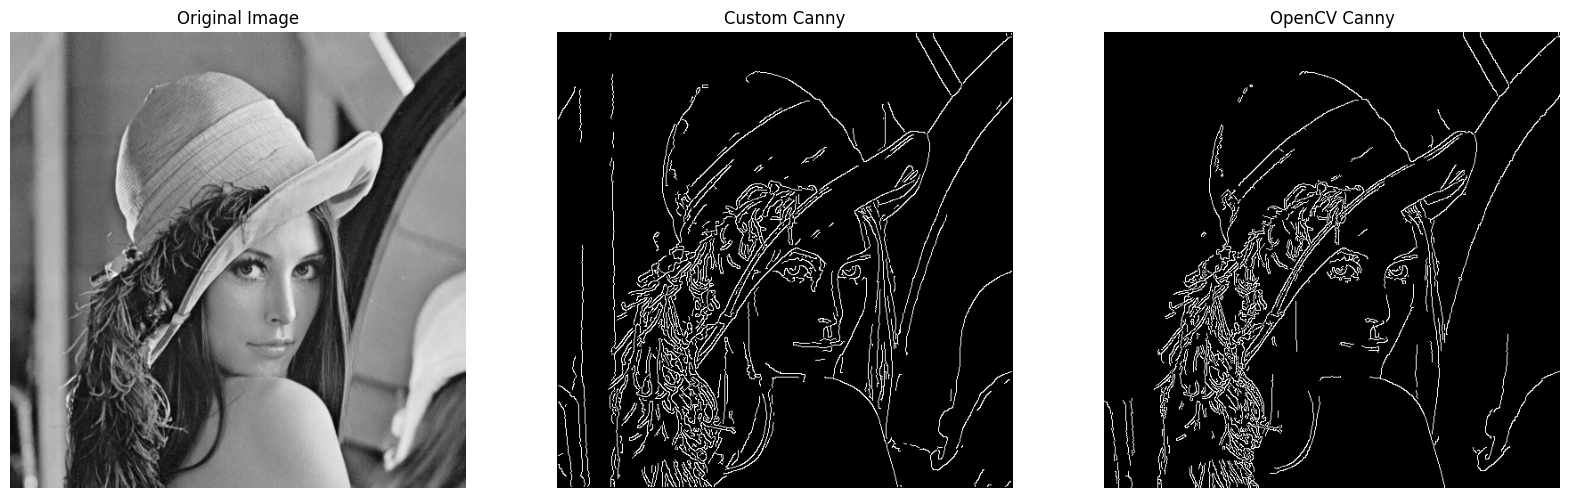

In [13]:
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve
import numpy as np

# 1.Noise reduction(가우시안 블러-노이즈 감소)
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

# 2.Gradient calculation(소벨 필터를 이용한 그래디언트 계산)
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.convolve(img, Kx)
    Iy = ndimage.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)   # magnitude
    G = G / G.max() * 255   # 정규화
    theta = np.arctan2(Iy, Ix) # 방향
    
    return (G, theta)

# 3. Non-maximum Suppression
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180.0 / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q, r = 255, 255

                # angle 범위에 따라 인접 픽셀 선택
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q, r = img[i, j+1], img[i, j-1]
                elif (22.5 <= angle[i,j] < 67.5):
                    q, r = img[i+1, j-1], img[i-1, j+1]
                elif (67.5 <= angle[i,j] < 112.5):
                    q, r = img[i+1, j], img[i-1, j]
                elif (112.5 <= angle[i,j] < 157.5):
                    q, r = img[i-1, j-1], img[i+1, j+1]

                # 현재 픽셀이 주변보다 크면 유지
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass

    return Z

# 4. Double Threshold
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.15):
    highThreshold = img.max() * highThresholdRatio  
    lowThreshold = highThreshold * lowThresholdRatio  

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(25) # 약한 픽셀 강도 값
    strong = np.int32(255) # 강한 픽셀 강도 값

    # strong, weak, zero 픽셀 위치를 결정
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    # strong, weak 픽셀 할당
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res, weak, strong)

# 5.Edge tracking by Hystersis
def hysteresis(img, weak, strong=255):
    M, N = img.shape
    res = np.copy(img)
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (res[i,j] == weak):
                # 주변 strong 픽셀이 하나라도 있으면 strong으로 승격, 없으면 0
                if ((res[i+1, j-1] == strong) or (res[i+1, j] == strong) or (res[i+1, j+1] == strong)
                    or (res[i, j-1] == strong) or (res[i, j+1] == strong)
                    or (res[i-1, j-1] == strong) or (res[i-1, j] == strong) or (res[i-1, j+1] == strong)):
                    res[i, j] = strong
                else:
                    res[i, j] = 0
    return res


# 메인 함수
if __name__ == "__main__":
    # 이미지 읽기
    src = cv2.imread('input_image.jpg', 0)

    # Custom Canny
    smoothed = ndimage.convolve(src / 255.0, gaussian_kernel(5)) # 1. 가우시안 스무딩
    G, theta = sobel_filters(smoothed) # 2. 그래디언트 계산
    nms = non_max_suppression(G, theta) # 3. Non-maximum Suppression
    res, weak, strong = threshold(nms) # 4. Double Threshold
    custom_canny = hysteresis(res, weak, strong) # 5. Hysteresis
    
    # OpenCV Canny
    opencv_canny = cv2.Canny(src, 100, 200)

    # 결과 시각화
    plt.figure(figsize=(20, 20))
    plt.subplot(131), plt.imshow(src, cmap='gray'), plt.axis('off'), plt.title('Original Image')
    plt.subplot(132), plt.imshow(custom_canny, cmap='gray'), plt.axis('off'), plt.title('Custom Canny')
    plt.subplot(133), plt.imshow(opencv_canny, cmap='gray'), plt.axis('off'), plt.title('OpenCV Canny')
    plt.show()